In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Open SOS Measurement Dataset, extract measurements

In [ ]:
start_date = '20221130'
end_date = '20230509'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)


alt.Chart(
    tidy_df[(tidy_df.time < '20221220') & (tidy_df["measurement"].isin(['w','v','u']))].query("height == 1")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color("measurement:N"),
    alt.Facet('tower:N'),
).properties(width=300, height=300)

## Add absolute humidity measurements by converting hygrometer measurements

In [ ]:
any(tidy_df[tidy_df.measurement=='mixing ratio'].height.unique() == 1)

In [ ]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

# Calibrate gas analyzer measurements

## Assume that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [ ]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [ ]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [ ]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

## Update dataset with corrections

In [ ]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

In [ ]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

In [ ]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [ ]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

In [ ]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]

alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

# Create wide df

In [ ]:
vars = [
    'dir_1m_ue', 'u_h2o__1m_ue', 'v_h2o__1m_ue', 'w_h2o__1m_ue',     'u_1m_ue',  'v_1m_ue',  'w_1m_ue', 
    'dir_3m_ue', 'u_h2o__3m_ue', 'v_h2o__3m_ue', 'w_h2o__3m_ue',     'u_3m_ue',  'v_3m_ue',  'w_3m_ue', 
    'dir_10m_ue', 'u_h2o__10m_ue','v_h2o__10m_ue', 'w_h2o__10m_ue',   'u_10m_ue',  'v_10m_ue', 'w_10m_ue',
    
    'dir_1m_uw', 'u_h2o__1m_uw', 'v_h2o__1m_uw', 'w_h2o__1m_uw',     'u_1m_uw',  'v_1m_uw',  'w_1m_uw', 
    'dir_3m_uw', 'u_h2o__3m_uw', 'v_h2o__3m_uw', 'w_h2o__3m_uw',     'u_3m_uw',  'v_3m_uw',  'w_3m_uw', 
    'dir_10m_uw', 'u_h2o__10m_uw','v_h2o__10m_uw', 'w_h2o__10m_uw',   'u_10m_uw',  'v_10m_uw', 'w_10m_uw',

    'dir_1m_d', 'u_h2o__1m_d', 'v_h2o__1m_d', 'w_h2o__1m_d',        'u_1m_d',   'v_1m_d',   'w_1m_d',  
    'dir_3m_d', 'u_h2o__3m_d', 'v_h2o__3m_d', 'w_h2o__3m_d',        'u_3m_d',   'v_3m_d',   'w_3m_d',  
    'dir_10m_d', 'u_h2o__10m_d','v_h2o__10m_d', 'w_h2o__10m_d',      'u_10m_d',  'v_10m_d',  'w_10m_d', 

    'dir_1m_c', 'u_h2o__1m_c', 'v_h2o__1m_c', 'w_h2o__1m_c',        'u_1m_c',   'v_1m_c',   'w_1m_c',   'specifichumidity_1m_c',    'airdensity_1m_c',
    'dir_2m_c', 'u_h2o__2m_c', 'v_h2o__2m_c', 'w_h2o__2m_c',        'u_2m_c',   'v_2m_c',   'w_2m_c',   'specifichumidity_2m_c',    'airdensity_2m_c',
    'dir_3m_c', 'u_h2o__3m_c', 'v_h2o__3m_c', 'w_h2o__3m_c',        'u_3m_c',   'v_3m_c',   'w_3m_c',   'specifichumidity_3m_c',    'airdensity_3m_c',
    'dir_5m_c', 'u_h2o__5m_c', 'v_h2o__5m_c', 'w_h2o__5m_c',        'u_5m_c',   'v_5m_c',   'w_5m_c',   'specifichumidity_5m_c',    'airdensity_5m_c',
    'dir_10m_c', 'u_h2o__10m_c','v_h2o__10m_c', 'w_h2o__10m_c',      'u_10m_c',  'v_10m_c',  'w_10m_c',  'specifichumidity_10m_c',   'airdensity_10m_c',
    'dir_15m_c', 'u_h2o__15m_c', 'v_h2o__15m_c', 'w_h2o__15m_c',     'u_15m_c',  'v_15m_c',  'w_15m_c',  'specifichumidity_15m_c',   'airdensity_15m_c',
    'dir_20m_c', 'u_h2o__20m_c', 'v_h2o__20m_c', 'w_h2o__20m_c',     'u_20m_c',  'v_20m_c',  'w_20m_c',  'specifichumidity_20m_c',   'airdensity_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 
    # 'T_12m_c',
      'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'Rsw_in_9m_d', 'Rnet_9m_d',

    'SF_avg_ue',

    'Ri_3m_c',

    'L_3m_c',
]

pivot_df = tidy_df[tidy_df.variable.isin(vars)][
    ['time', 'variable', 'value']
].pivot_table(index='time', columns='variable', values='value')


assert len(vars) == len(pivot_df.columns.unique())

In [ ]:
set(vars).difference(set(pivot_df.columns.unique()))

In [ ]:
[ v in tidy_df.variable.unique() for v in vars ]

In [ ]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

# Create table with instrument location info 

We use a file with theodolite/GPS readings provided by NCAR. 

In [275]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

# Create tables

## Wind field measurements

In [ ]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin([1,3,10])]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df.head()

## Turbulent water vapor flux measurements

In [ ]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin([1,3,10])]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df.head()

## Humidity measurements

In [ ]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df[abs_hum_field_df.height == 1]

In [306]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

height                             1.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.6355              1.1561   
2022-11-30 00:30:00              0.7348              1.2510   
2022-11-30 01:00:00              0.7671              1.2537   
2022-11-30 01:30:00              0.7242              1.2071   
2022-11-30 02:00:00              0.7210              1.2501   
...                                 ...                 ...   
2023-05-09 15:30:00              2.6024                 NaN   
2023-05-09 16:00:00              2.5730                 NaN   
2023-05-09 16:30:00              2.8056                 NaN   
2023-05-09 17:00:00              2.6395                 NaN   
2023-05-09 17:30:00              3.0323                 NaN   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.8129              0.6652   
2022-11-30 00:30:00              0.8063              0.6783   
2022-11-30 01:00:00              0.8071              0.6670   
2022-11-30 01:30:00              0.8064              0.6342   
2022-11-30 02:00:00              0.8075              0.6270   
...                                 ...                 ...   
2023-05-09 15:30:00                 NaN                 NaN   
2023-05-09 16:00:00                 NaN                 NaN   
2023-05-09 16:30:00                 NaN                 NaN   
2023-05-09 17:00:00                 NaN                 NaN   
2023-05-09 17:30:00                 NaN                 NaN   

height                             3.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              1.2019              0.7553   
2022-11-30 00:30:00              1.3128              0.7867   
2022-11-30 01:00:00              1.3324              0.7876   
2022-11-30 01:30:00              1.3038              0.7969   
2022-11-30 02:00:00              1.3360              0.6982   
...                                 ...                 ...   
2023-05-09 15:30:00              2.4664              2.6617   
2023-05-09 16:00:00              2.4660              2.6428   
2023-05-09 16:30:00              2.6200              2.8197   
2023-05-09 17:00:00              2.5135              2.7082   
2023-05-09 17:30:00              2.7600              2.9733   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.7909              0.8705   
2022-11-30 00:30:00              0.7596              0.9388   
2022-11-30 01:00:00              0.7876              0.9670   
2022-11-30 01:30:00              0.8061              0.9272   
2022-11-30 02:00:00              0.7069              0.9474   
...                                 ...                 ...   
2023-05-09 15:30:00              2.5909              2.7364   
2023-05-09 16:00:00              2.5880              2.7249   
2023-05-09 16:30:00              2.7385              2.9030   
2023-05-09 17:00:00              2.6553              2.7873   
2023-05-09 17:30:00              2.8969              3.0886   

height                             10.0                      \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                       

## Advective flux measurements

In [ ]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['u'] = this_wind_df['u']*this_abs_hum_df['Water vapor density']
        this_wind_df['v'] = this_wind_df['v']*this_abs_hum_df['Water vapor density']
        this_wind_df['w'] = this_wind_df['w']*this_abs_hum_df['Water vapor density']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new)

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df.head()

# Create an interpolated wind field from measurements

## 2D example

In [ ]:
wind_field_df.iloc[0][3]

In [ ]:
def divergence_2d(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

In [ ]:

# for i in [0,10,5]:
divergences_dict = {}
for HEIGHT in [1,3,10]:
    divergences_ls = []
    for i in range(0, wind_field_df.shape[0]):
        
        x = instrument_loc_df.loc[(HEIGHT)][['x']]
        y = instrument_loc_df.loc[(HEIGHT)][['y']]

        wind_field_vals = pd.DataFrame(wind_field_df.iloc[i][HEIGHT]).reset_index().set_index('tower').pivot(columns='measurement')
        wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
        points_and_wind_fields = x.join(y).join(wind_field_vals)
        xx = np.linspace(
            points_and_wind_fields.x.min()-5, 
            points_and_wind_fields.x.max()-5, 25
        )
        yy = np.linspace(
            points_and_wind_fields.y.min()+5, 
            points_and_wind_fields.y.max()+5, 25
        )
        xx, yy = np.meshgrid(xx, yy)
        points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y)))
        u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy), method='linear')
        v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy), method='linear')

        F = np.array([u_interp, v_interp])
        div = divergence_2d(F)
        divergences_ls.append(div)
        
    divergences_dict[HEIGHT] = divergences_ls
        # # we just have one density measurement at this height, so simply spread the
        # # measured density value across all the points
        # # rho_interp = np.full(u_interp.shape, src_3_c_density[i][0])

        # fig, ax = plt.subplots(figsize=(4,4))
        # ax.quiver(
        #     points_and_wind_fields.x, 
        #     points_and_wind_fields.y, 
        #     points_and_wind_fields.u, 
        #     points_and_wind_fields.v, 
        #     color='red', 
        #     label='measured'
        # )
        # ax.ticklabel_format(useOffset=False, style='plain')
        # ax.quiver(xx, yy, u_interp, v_interp, label='interpolated')
        # ax.ticklabel_format(useOffset=False, style='plain')
        # ax.legend(loc='upper right')

## 3D example

In [ ]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

for i in [0]:
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    ax.quiver(
        points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z, 
        points_and_wind_fields.u, points_and_wind_fields.v, points_and_wind_fields.w,
        color='red', label='measured', pivot='middle'
    )
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.quiver(xx, yy, zz, u_interp, v_interp, w_interp, label='interpolated', pivot='middle')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend()

## 3D divergence calculations (volumetric)

In [ ]:
def divergence(f,sp):
    """ Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

In [ ]:
points_and_wind_fields.z.max() - points_and_wind_fields.z.min()

In [276]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
mean_divergences_lateral_bylayer = []
mean_divergences_vertical_bylayer = []
for i in range(0, wind_field_df.shape[0]):
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))
    mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
    mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))

assert len(wind_field_df) == len(mean_divergences)
windfield_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=wind_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2776874732.py:46: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2776874732.py:47: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2776874732.py:46: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2776874732.py:47: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2776874732.py:46: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52b

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/173837718.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/173837718.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/173837718.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


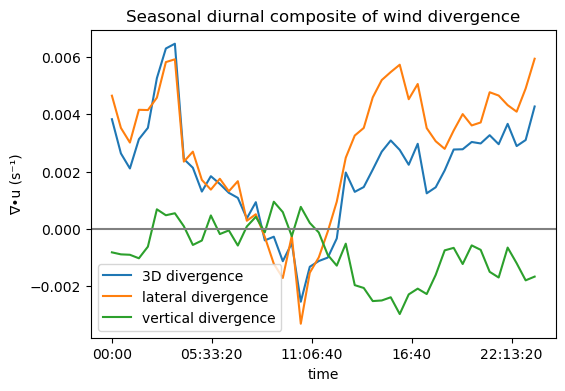

In [277]:
windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•u (s⁻¹)")
plt.title("Seasonal diurnal composite of wind divergence")
plt.legend()

<Axes: xlabel='time'>

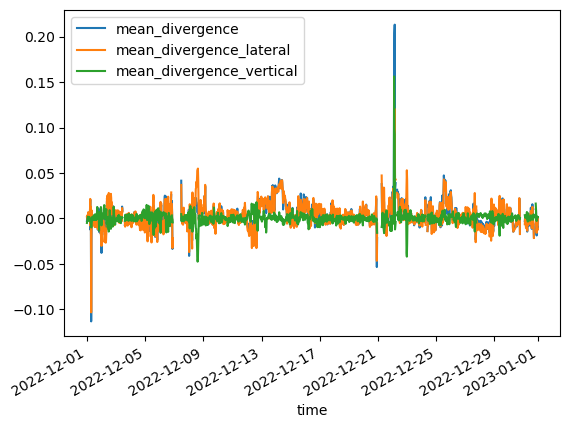

In [278]:
windfield_div_df.loc['20221201': '20221231'].plot()

In [279]:
src_lateral_bylayer = pd.DataFrame(mean_divergences_lateral_bylayer)
src_lateral_bylayer.index = wind_field_df.index

src_vertical_bylayer = pd.DataFrame(mean_divergences_vertical_bylayer)
src_vertical_bylayer.index = wind_field_df.index

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1113910705.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src = src_lateral_bylayer.groupby(src_lateral_bylayer.index.floor('30T').time).median().dropna(axis=1)


Text(0.5, 1.0, 'Horizontal wind divergence at different heights in the control volume')

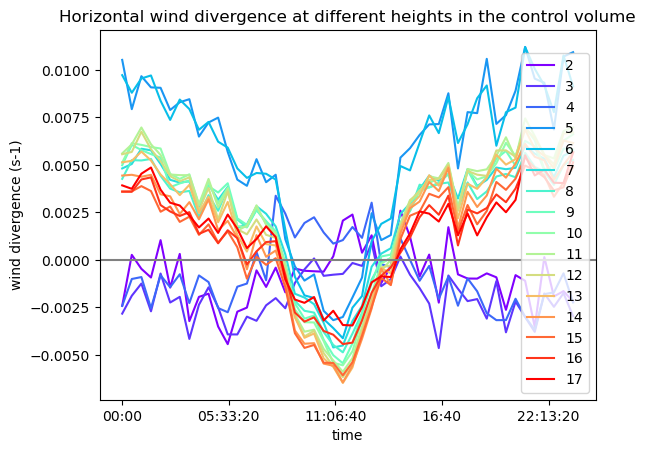

In [282]:
src = src_lateral_bylayer.groupby(src_lateral_bylayer.index.floor('30T').time).median().dropna(axis=1)
src.plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Horizontal wind divergence at different heights in the control volume")

In [283]:
src['0.5 - 2 m'] = np.mean(src[[2,3,4]], axis=1)
src['2.5 - 3.5m'] = np.mean(src[[5,6,7]], axis=1)
src['4 - 5.0m'] = np.mean(src[[8,9,10]], axis=1)
src['5.5 - 6.5m'] = np.mean(src[[11,12,13]], axis=1)
src['7 - 8.5m'] = np.mean(src[[14,15,16, 17]], axis=1)

Text(0.5, 1.0, 'Horizontal wind divergence at different heights in the control volume')

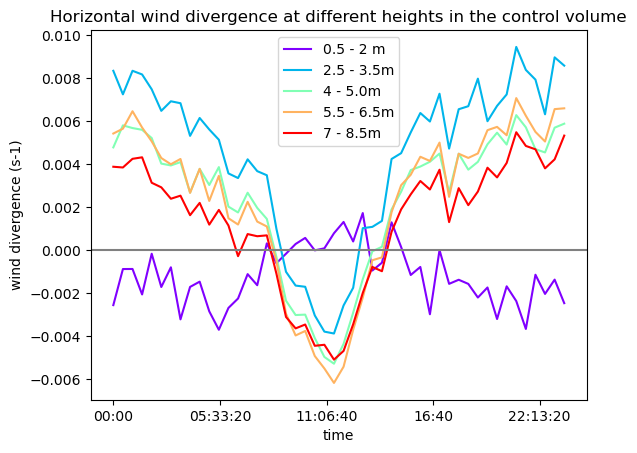

In [284]:
src[['0.5 - 2 m', '2.5 - 3.5m', '4 - 5.0m', '5.5 - 6.5m', '7 - 8.5m', ]].plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Horizontal wind divergence at different heights in the control volume")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1747514091.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src = src_vertical_bylayer.groupby(src_vertical_bylayer.index.floor('30T').time).median().dropna(axis=1)


Text(0.5, 1.0, 'Horizontal wind divergence at different heights in the control volume')

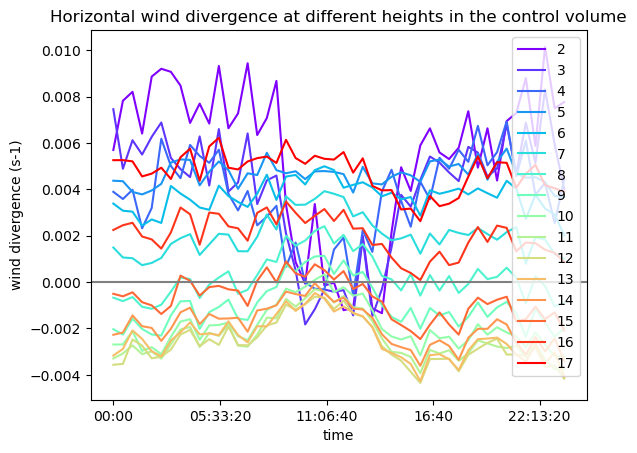

In [285]:
src = src_vertical_bylayer.groupby(src_vertical_bylayer.index.floor('30T').time).median().dropna(axis=1)
src.plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Vertical wind divergence at different heights in the control volume")

In [286]:
src['0.5 - 2 m'] = np.mean(src[[2,3,4]], axis=1)
src['2.5 - 3.5m'] = np.mean(src[[5,6,7]], axis=1)
src['4 - 5.0m'] = np.mean(src[[8,9,10]], axis=1)
src['5.5 - 6.5m'] = np.mean(src[[11,12,13]], axis=1)
src['7 - 8.5m'] = np.mean(src[[14,15,16, 17]], axis=1)

Text(0.5, 1.0, 'Vertical wind divergence at different heights in the control volume')

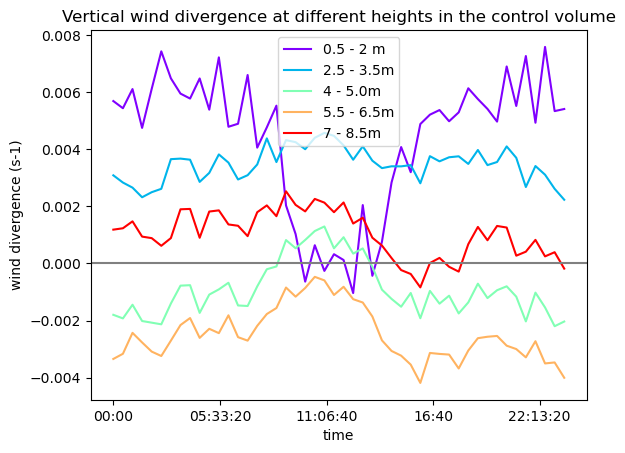

In [288]:
src[['0.5 - 2 m', '2.5 - 3.5m', '4 - 5.0m', '5.5 - 6.5m', '7 - 8.5m', ]].plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Vertical wind divergence at different heights in the control volume")

## 3D divergence calculations (advected water vapor)

### Using form: $\frac{\partial}{\partial x_i} (u_i q) $

In [289]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, adv_flux_field_df.shape[0]):
    adv_flux_field_vals = pd.DataFrame(adv_flux_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    adv_flux_field_vals.columns = adv_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(adv_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(adv_flux_field_df) == len(mean_divergences)
adv_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=adv_flux_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3182976858.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1240857252.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1240857252.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1240857252.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


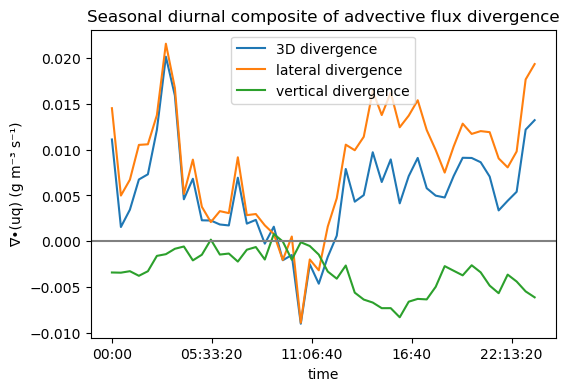

In [290]:
adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.legend()

### Using form: $u_i \frac{\partial q}{\partial x_i} = u_i \nabla \cdot \frac{\partial q}{\partial x_i}$

$u \frac{\partial q}{\partial x} + v \frac{\partial q}{\partial y} + w \frac{\partial q}{\partial z}$

In [339]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, abs_hum_field_df.shape[0]):
    # Get abs. humidity data
    abs_humidity_field_vals = pd.DataFrame(abs_hum_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    abs_humidity_field_vals.columns = abs_humidity_field_vals.columns.droplevel(0)
    points_and_abs_humidity_field = x.join(y).join(z).join(abs_humidity_field_vals, how='right')

    # Get wind field data
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    # Create meshgrid
    xx = np.linspace(
        points_and_abs_humidity_field.x.min(), 
        points_and_abs_humidity_field.x.max(), 50
    )
    yy = np.linspace(
        points_and_abs_humidity_field.y.min(), 
        points_and_abs_humidity_field.y.max(), 50
    )
    zz = np.linspace(
        points_and_abs_humidity_field.z.min(), 
        points_and_abs_humidity_field.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)

    # Get points
    points = np.transpose(np.vstack((points_and_abs_humidity_field.x, points_and_abs_humidity_field.y, points_and_abs_humidity_field.z)))

    # Interpolate abs. humidity field
    abs_humidity_interp = interpolate.griddata(points, points_and_abs_humidity_field['Water vapor density'], (xx, yy, zz), method='linear')

    # Interpolate wind field
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    # Create wind-field 3D array
    F_windfield = np.array([u_interp, v_interp, w_interp])
    F_windfield_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_windfield_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]

    dq_over_dx = np.gradient(abs_humidity_interp, axis=0)
    dq_over_dy = np.gradient(abs_humidity_interp, axis=1)
    dq_over_dz = np.gradient(abs_humidity_interp, axis=2)
    g_lateral = u_interp * dq_over_dx + v_interp * dq_over_dy
    g_vertical = w_interp * dq_over_dz
    g = g_lateral + g_vertical
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(abs_hum_field_df) == len(mean_divergences)
adv_flux_div_method2_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=abs_hum_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/158144217.py:60: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/158144217.py:61: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/158144217.py:62: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/158144217.py:60: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/158144217.py:61: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/158144217.py:62: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3358554794.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3358554794.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/3358554794.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4)

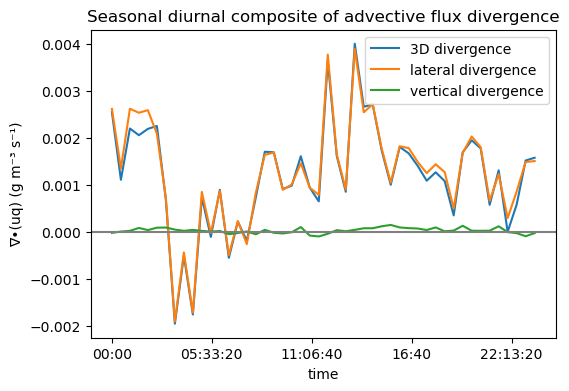

In [340]:
adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.legend()

## 3D divergence calculations (turb. diffused water vapor)

In [344]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, turb_flux_field_df.shape[0]):
    turb_flux_field_vals = pd.DataFrame(turb_flux_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    turb_flux_field_vals.columns = turb_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(turb_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u_h2o_, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v_h2o_, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w_h2o_, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(turb_flux_field_df) == len(mean_divergences)
turb_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=turb_flux_field_df.index
)

KeyboardInterrupt: 

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2277150821.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2277150821.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/2277150821.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


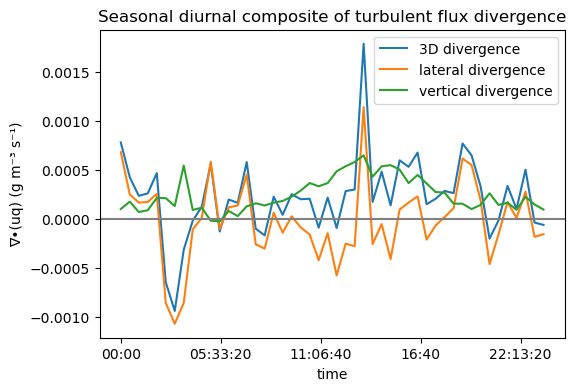

In [342]:
turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of turbulent flux divergence")
plt.legend()

In [345]:
display(turb_flux_div_df.head())
display(adv_flux_div_df.head())
display(adv_flux_div_method2_df.head())
display(windfield_div_df.head())

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-30 00:00:00        -0.000348                -0.000475   
2022-11-30 00:30:00        -0.000068                -0.000179   
2022-11-30 01:00:00        -0.000041                -0.000049   
2022-11-30 01:30:00         0.000003                -0.000038   
2022-11-30 02:00:00        -0.000434                -0.000397   

                     mean_divergence_vertical  
time                                           
2022-11-30 00:00:00                  0.000127  
2022-11-30 00:30:00                  0.000111  
2022-11-30 01:00:00                  0.000008  
2022-11-30 01:30:00                  0.000041  
2022-11-30 02:00:00                 -0.000037

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-30 00:00:00         0.003368                 0.004452   
2022-11-30 00:30:00         0.006168                 0.003294   
2022-11-30 01:00:00         0.009325                 0.008837   
2022-11-30 01:30:00         0.006961                 0.011619   
2022-11-30 02:00:00         0.005432                 0.002477   

                     mean_divergence_vertical  
time                                           
2022-11-30 00:00:00                 -0.001084  
2022-11-30 00:30:00                  0.002874  
2022-11-30 01:00:00                  0.000488  
2022-11-30 01:30:00                 -0.004658  
2022-11-30 02:00:00                  0.002955

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-30 00:00:00         0.001676                 0.000887   
2022-11-30 00:30:00         0.004023                 0.003070   
2022-11-30 01:00:00         0.001701                 0.000891   
2022-11-30 01:30:00         0.001448                 0.000771   
2022-11-30 02:00:00         0.004645                 0.003486   

                     mean_divergence_vertical  
time                                           
2022-11-30 00:00:00                  0.000383  
2022-11-30 00:30:00                  0.000314  
2022-11-30 01:00:00                  0.000346  
2022-11-30 01:30:00                  0.000222  
2022-11-30 02:00:00                  0.000502

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-30 00:00:00         0.000871                -0.000234   
2022-11-30 00:30:00         0.000180                -0.002994   
2022-11-30 01:00:00         0.006452                 0.005307   
2022-11-30 01:30:00         0.003361                 0.006294   
2022-11-30 02:00:00        -0.001457                -0.004787   

                     mean_divergence_vertical  
time                                           
2022-11-30 00:00:00                  0.001105  
2022-11-30 00:30:00                  0.003174  
2022-11-30 01:00:00                  0.001145  
2022-11-30 01:30:00                 -0.002933  
2022-11-30 02:00:00                  0.003331

# Plot all results

In [398]:
combo_df = pd.concat([
    turb_flux_div_df.assign(flux='turbulent flux'),
    # adv_flux_div_df.assign(flux='advective flux'),
    adv_flux_div_method2_df.assign(flux='advective'),
    windfield_div_df.assign(flux='volumetric flux')
])
combo_df = combo_df[combo_df.index.isin(nobs_times)]

In [399]:
(
    alt.Chart(combo_df.reset_index()).transform_filter(
        alt.datum.flux == 'volumetric flux'
    ).transform_fold([
        'mean_divergence',
        'mean_divergence_lateral',
        'mean_divergence_vertical'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (1/s)'),
        alt.Column('flux:N'),
        alt.Color('key:N')
    ).properties(width=150, height = 150) 
    | 
    alt.Chart(combo_df.reset_index()).transform_filter(
        alt.datum.flux != 'volumetric flux'
    ).transform_fold([
        'mean_divergence',
        'mean_divergence_lateral',
        'mean_divergence_vertical'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (g/m^3/s)'),
        alt.Column('flux:N'),
        alt.Color('key:N')
    ).properties(width=150, height = 150).resolve_scale(y='shared')
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [385]:
(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("w'q' (g/m^2/s)"),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['airdensity_3m_c', 'airdensity_10m_c', 'airdensity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['specifichumidity_3m_c', 'specifichumidity_10m_c', 'specifichumidity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
).resolve_scale(color='independent').configure_legend(orient='top').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [387]:
combo_df_area_norm = combo_df.copy(deep=True)
combo_df_area_norm[[
    'mean_divergence', 'mean_divergence_lateral', 'mean_divergence_vertical']
] = combo_df_area_norm[[
    'mean_divergence', 'mean_divergence_lateral', 'mean_divergence_vertical']] * 7

In [395]:
(
    alt.Chart(combo_df_area_norm.reset_index()).transform_filter(
        alt.datum.flux == 'volumetric flux'
    ).transform_fold([
        'mean_divergence',
        'mean_divergence_lateral',
        'mean_divergence_vertical'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (1/m^2/s)'),
        alt.Column('flux:N'),
        alt.Color('key:N')
    ).properties(width=150, height = 150) 
    | 
    (
        alt.Chart(combo_df_area_norm.reset_index()).transform_filter(
            alt.datum.flux != 'volumetric flux'
        ).transform_fold([
            'mean_divergence',
            'mean_divergence_lateral',
            'mean_divergence_vertical'
        ]).mark_line().encode(
            alt.X('hours(time):T').title('time of day'),
            alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
            alt.Column('flux:N'),
            alt.Color('key:N')
        ).properties(width=150, height = 150)
        | 
        alt.Chart(
            tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c'])]
        ).mark_line().encode(
            alt.X("hours(time):T"),
            alt.Y("median(value):Q").title("w'q' (g/m^2/s)"),
            alt.Color('height:O').scale(scheme='greys')
        ).properties(width=150, height = 150) 
    ).resolve_scale(y='shared', color='independent')   
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Compare with results from the Control Volume approach

In [298]:
cv_df = pd.read_csv('flux_divergence_3d_control_volume.csv').set_index('time')
cv_df.index = pd.to_datetime(cv_df.index)
cv_df.columns[-16:]

Index(['w_h2o__3m_uw', 'w_h2o__5m_c', 'delta water storage (g/s)',
       'absolute humidity (g/m^3)', 'wind_divergence_integrated',
       'total_turb_lateral_divergence (g/s)',
       'total_turb_vertical_divergence (g/s)', 'total_turb_divergence (g/s)',
       'total_adv_lateral_divergence (g/s)',
       'total_adv_vertical_divergence (g/s)', 'total_adv_divergence (g/s)',
       'source (g/s)', 'EC-estimated surface sublimation (g/s)',
       'EC-estimated surface sublimation (g/m^2/s)',
       'CV-estimated surface sublimation (g/s)',
       'CV-estimated surface sublimation (g/m^2/s)'],
      dtype='object')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1048407404.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1048407404.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()


<Axes: xlabel='time'>

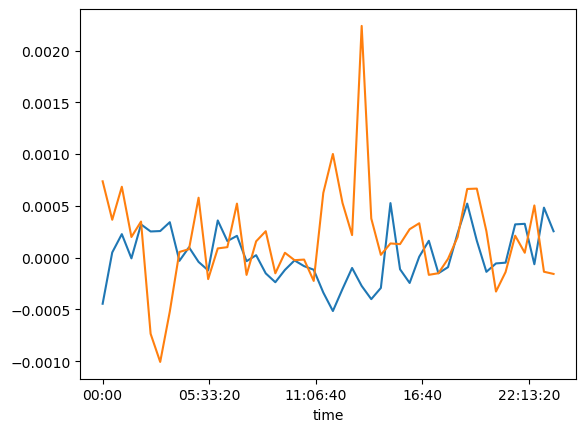

In [299]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1048407404.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/1048407404.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()


<Axes: xlabel='time'>

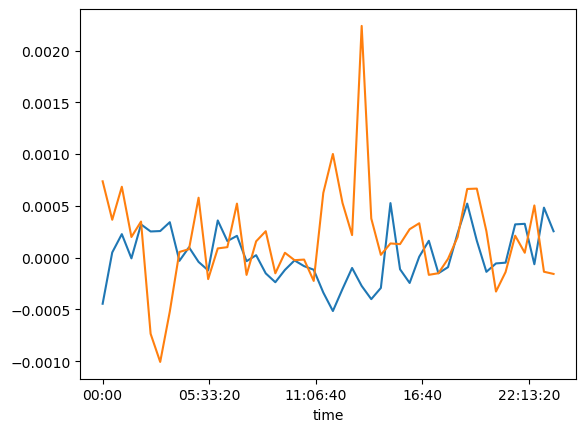

In [300]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/443378056.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_adv_divergence (g/s)'].plot()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25474/443378056.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.groupby(adv_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()


<Axes: xlabel='time'>

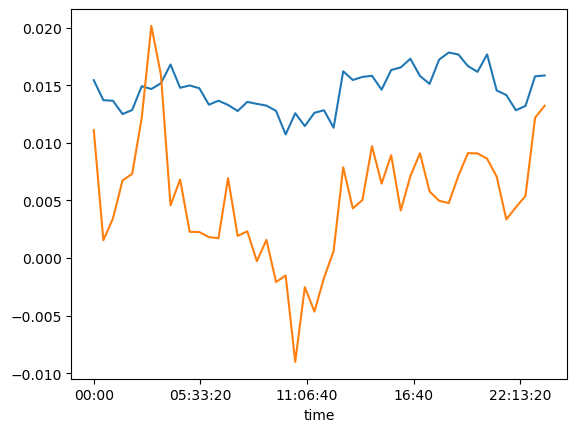

In [301]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_adv_divergence (g/s)'].plot()
adv_flux_div_df.groupby(adv_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [302]:
zz.max() - zz.min()

12.617400000000089

In [303]:
cv_df.head()

L_3m_c   Ri_3m_c  Rnet_9m_d  Rsw_in_9m_d  SF_avg_ue  \
time                                                                         
2022-11-30 00:00:00 -9.415350  0.104434        NaN          NaN        0.0   
2022-11-30 00:30:00 -5.233014  1.948613        NaN          NaN        0.0   
2022-11-30 01:00:00 -0.390947  0.439835        NaN          NaN        0.0   
2022-11-30 01:30:00 -1.862847  0.129571        NaN          NaN        0.0   
2022-11-30 02:00:00 -0.507616  0.925115        NaN          NaN        0.0   

                       T_10m_c    T_11m_c  T_12m_c    T_13m_c    T_14m_c  ...  \
time                                                                      ...   
2022-11-30 00:00:00 -18.661501 -18.507807      NaN -18.224882 -18.060904  ...   
2022-11-30 00:30:00 -18.495649 -18.489271      NaN -18.439085 -18.331961  ...   
2022-11-30 01:00:00 -18.769953 -18.752583      NaN -18.655046 -18.538708  ...   
2022-11-30 01:30:00 -18.784357 -18.704370      NaN -18.482471 -18.305851  ...   
2022-11-30 02:00:00 -18.410257 -18.378786      NaN -18.277784 -18.153341  ...   

                     total_turb_vertical_divergence (g/s)  \
time                                                        
2022-11-30 00:00:00                              0.000104   
2022-11-30 00:30:00                              0.000135   
2022-11-30 01:00:00                              0.000026   
2022-11-30 01:30:00                              0.000056   
2022-11-30 02:00:00                              0.000111   

                     total_turb_divergence (g/s)  \
time                                               
2022-11-30 00:00:00                     0.000028   
2022-11-30 00:30:00                    -0.000114   
2022-11-30 01:00:00                     0.000101   
2022-11-30 01:30:00                     0.000077   
2022-11-30 02:00:00                    -0.000050   

                     total_adv_lateral_divergence (g/s)  \
time                                                      
2022-11-30 00:00:00                            0.008436   
2022-11-30 00:30:00                            0.003383   
2022-11-30 01:00:00                            0.004101   
2022-11-30 01:30:00                            0.009535   
2022-11-30 02:00:00                            0.001269   

                     total_adv_vertical_divergence (g/s)  \
time                                                       
2022-11-30 00:00:00                             0.000431   
2022-11-30 00:30:00                             0.003395   
2022-11-30 01:00:00                             0.001657   
2022-11-30 01:30:00                            -0.002774   
2022-11-30 02:00:00                             0.003291   

                     total_adv_divergence (g/s)  source (g/s)  \
time                                                            
2022-11-30 00:00:00                    0.008867           NaN   
2022-11-30 00:30:00                    0.006779      0.050508   
2022-11-30 01:00:00                    0.005758     -0.013030   
2022-11-30 01:30:00                    0.006762      0.012701   
2022-11-30 02:00:00                    0.004560      0.071802   

                     EC-estimated surface sublimation (g/s)  \
time                                                          
2022-11-30 00:00:00                               -0.315665   
2022-11-30 00:30:00                               -0.419700   
2022-11-30 01:00:00                               -0.313276   
2022-11-30 01:30:00                               -0.194825   
2022-11-30 02:00:00                               -0.519534   

                     EC-estimated surface sublimation (g/m^2/s)  \
time                                                              
2022-11-30 00:00:00                                   -0.000544   
2022-11-30 00:30:00                                   -0.000723   
2022-11-30 01:00:00                                   -0.000540   
2022-11-30 01:30:00                            

In [304]:

windfield_div_df

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-30 00:00:00         0.000871                -0.000234   
2022-11-30 00:30:00         0.000180                -0.002994   
2022-11-30 01:00:00         0.006452                 0.005307   
2022-11-30 01:30:00         0.003361                 0.006294   
2022-11-30 02:00:00        -0.001457                -0.004787   
...                              ...                      ...   
2023-05-09 15:30:00         0.000682                 0.002219   
2023-05-09 16:00:00        -0.003055                 0.003280   
2023-05-09 16:30:00         0.004011                 0.004941   
2023-05-09 17:00:00         0.001015                 0.008611   
2023-05-09 17:30:00         0.003053                 0.007408   

                     mean_divergence_vertical  
time                                           
2022-11-30 00:00:00                  0.001105  
2022-11-30 00:30:00                  0.003174  
2022-11-30 01:00:00                  0.001145  
2022-11-30 01:30:00                 -0.002933  
2022-11-30 02:00:00                  0.003331  
...                                       ...  
2023-05-09 15:30:00                 -0.001537  
2023-05-09 16:00:00                 -0.006335  
2023-05-09 16:30:00                 -0.000930  
2023-05-09 17:00:00                 -0.007596  
2023-05-09 17:30:00                 -0.004354  

[7485 rows x 3 columns]